# Excess properties for the chloroform/methanol mixture

In this document we compare the excess properties calculated by `F-SAC` with experimental data for the chloforom/methanol mixture.

We will use the JCOSMO implementation, make sure you download it at the [LVPP website](https://ufrgs.br/lvpp) and have it running on your machine.

In [9]:
import math, os, sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

parent_directory = os.path.dirname(os.path.abspath('.'))
sys.path.append(parent_directory)

from pysac import SAC, RGAS, RGAS_SI, DEFAULT_Q_EFF

from py4j.java_gateway import JavaGateway
gateway = JavaGateway(auto_field=True)
JCOSMO = gateway.entry_point

# List the available models
try:
	model = JCOSMO.newModel('F-SAC2')
except:
	print('Could not connect to JCOSMO, make sure it is running.')
	quit()

## Compounds and sigma-profiles with F-SAC

In F-SAC, compounds are defined with a few surface areas and their respective charge densities.

The basic literature is:
 - [Functional-Segment Activity Coefficient model. 1. Model formulation](http://dx.doi.org/10.1021/ie400170a). Industrial & Engineering Chemistry Research, v. 52, p. 11159-11171, 2013.
 - [Functional-Segment Activity Coefficient model. 2. Associating mixtures](http://dx.doi.org/10.1021/ie4013979). Industrial & Engineering Chemistry Research, v. 52, p. 11172-11181, 2013.

Our first compound, **chloroform** and the second is **acetone**.


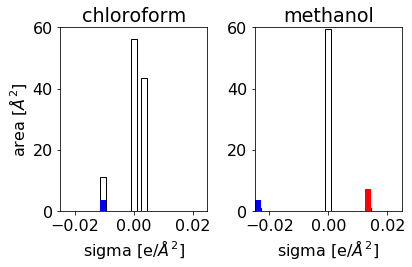

In [10]:
ncomps = 2
comps = gateway.new_array(gateway.jvm.java.lang.String, ncomps)
comps[0] = 'CHLOROFORM'
comps[1] = 'METHANOL'

model.setCompounds(comps)
comps = model.getComps()

Q = []
Qdon = []
Qacc = []
sigma = comps[0].sigmaAvg
for m in range(len(sigma)) :
    if comps[0].type[m] == 0:
        Q.append(comps[0].area[m])
        Qacc.append(0.0)
        Qdon.append(0.0)
    else :
        Q.append(0.0)
        if sigma[m] < 0:
            Qdon.append(comps[0].area[m])
            Qacc.append(0.0)
        else:
            Qacc.append(comps[0].area[m])
            Qdon.append(0.0)

plt.subplot(1, 2, 1)
plt.bar(sigma, Q, color='k', fill=False, width = 0.002)
plt.bar(sigma, Qdon, bottom=Q, color='b', width = 0.002)
plt.bar(sigma, Qacc, bottom=Q, color='r', width = 0.002)
plt.title(r'chloroform')
plt.xlabel(r'sigma [e/$\AA^2$]')
plt.ylabel(r'area [$\AA^2$]')
plt.ylim([0, 60])
plt.xlim([-0.025, 0.025])

Q = []
Qdon = []
Qacc = []
sigma = comps[1].sigmaAvg
for m in range(len(sigma)) :
    if comps[1].type[m] == 0:
        Q.append(comps[1].area[m])
        Qacc.append(0.0)
        Qdon.append(0.0)
    else :
        Q.append(0.0)
        if sigma[m] < 0:
            Qdon.append(comps[1].area[m])
            Qacc.append(0.0)
        else:
            Qacc.append(comps[1].area[m])
            Qdon.append(0.0)

plt.subplot(1, 2, 2)
plt.bar(sigma, Q, color='k', fill=False, width = 0.002)
plt.bar(sigma, Qdon, bottom=Q, color='b', width = 0.002)
plt.bar(sigma, Qacc, bottom=Q, color='r', width = 0.002)
plt.title('methanol')
plt.xlabel(r'sigma [e/$\AA^2$]')
plt.xlim([-0.025, 0.025])
plt.ylim([0, 60])

plt.rcParams.update({'font.size': 16})
plt.tight_layout()
plt.savefig('pdf/f-sac-profiles-chloroform-methanol.pdf')
plt.show()

## Excess properties

Here we calculate the excess properties on multiple compositions and compare the F-SAC results with experimental data.

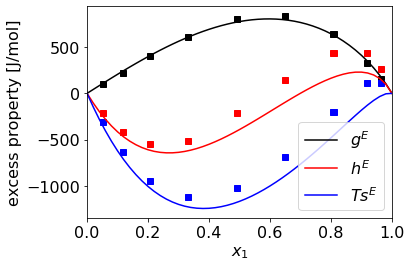

In [11]:
T = 308.13
N = 51
ue = []
ae = []
tse = []

# Experimental data from NIST TDE, Gibbs excess was smothed from VLE assuming valid the modified Raout's law.
x1_exp = [0.051, 0.117, 0.208, 0.331, 0.493, 0.65, 0.808, 0.809, 0.919, 0.965]
ge_exp = [95.76, 223.73, 399.23, 613.81, 807.56, 836.22, 639.67, 637.57, 330.34, 154.28]
he_exp = [-213, -414, -548, -511, -213, 147, 440, 440, 440, 264]
tse_exp = []
for i in range(len(ge_exp)):
    tse_exp.append(he_exp[i] - ge_exp[i])

x1 = []

x = gateway.new_array(gateway.jvm.double,ncomps)
model.setTemperature(T)

for l in range(N):
    x1_ = l/(N-1)
    x1.append(x1_)

    x[0] = x1_
    x[1] = 1 - x1_
    model.setComposition(x)
    model.activityCoefficientLn()

    he_ = model.excessEnthalpy()
    ge_ = model.excessGibbs()
    tse_ = he_ - ge_

    ae.append(ge_ * RGAS_SI * T)
    ue.append(he_ * RGAS_SI * T)
    tse.append(tse_ * RGAS_SI * T)

plt.plot(x1_exp, ge_exp, 'ks')
plt.plot(x1_exp, he_exp, 'rs')
plt.plot(x1_exp, tse_exp, 'bs')
plt.plot(x1, ae, 'k-', label=r'$g^E$')
plt.plot(x1, ue, 'r-', label=r'$h^E$')
plt.plot(x1, tse, 'b-', label=r'$Ts^E$')

plt.legend(loc='lower right')
plt.xlabel(r'$x_1$')
plt.ylabel(r'excess property [J/mol]')
plt.xlim([0, 1])
#plt.ylim([-0.6, 0.6])

plt.rcParams.update({'font.size': 16})
plt.tight_layout()
plt.plot()
plt.savefig('pdf/chloroform-methanol-excess.pdf')